# IT & 과학 낚시성 기사 탐지 데이터


## [1] 데이터 준비


In [1]:
import os
import json
import pandas as pd
from collections import Counter
import torch.optim.lr_scheduler as lr_scheduler


In [2]:
PATH = "DATA/"
file_list = os.listdir(PATH)

file_list


['clickbait', 'non_clickbait']

In [3]:
# 데이터프레임 만들기

news_data_non_clickbait = []
news_data_clickbait = []

for file_name in file_list:
    for root, dirs, files in os.walk(PATH + file_name):
        # os.walk를 사용하면 root, dirs, file명 반환
        print(f"{file_name} 하위 파일 개수 : {len(files)}")
        for file in files:
            with open(root + "/" + file, "r", encoding="utf-8") as f:

                data = json.load(f)
                data_text = data["sourceDataInfo"]["newsContent"]

                if file_name == "non_clickbait":
                    news_data_non_clickbait.append(data_text)
                else:
                    news_data_clickbait.append(data_text)


clickbait 하위 파일 개수 : 20784
non_clickbait 하위 파일 개수 : 19900


In [4]:
news_data_non_clickbait_df = pd.DataFrame({"text": news_data_non_clickbait, "label": 0})
news_data_clickbait_df = pd.DataFrame({"text": news_data_clickbait, "label": 1})


*   label 0 : non_clickbait
*   label 1 : clickbait


In [5]:
news_data_non_clickbait_df.to_csv("news_data_non_clickbait_df.csv")


In [6]:
news_data_clickbait_df.to_csv("news_data_clickbait_df.csv")


In [7]:
len(news_data_non_clickbait_df), len(news_data_clickbait_df)


(19900, 20784)

In [8]:
news_data_non_clickbait_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19900 entries, 0 to 19899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    19900 non-null  object
 1   label   19900 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 311.1+ KB


In [9]:
news_data_clickbait_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20784 entries, 0 to 20783
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20784 non-null  object
 1   label   20784 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 324.9+ KB


In [10]:
news_data = pd.concat([news_data_non_clickbait_df, news_data_clickbait_df], axis=0)


## [2] Train, Valid, Test 데이터 분리


In [11]:
train = news_data.sample(frac=0.8, random_state=12)  # 90%만 뽑아서 train
test = news_data.drop(train.index)  # drop한 나머지 10%를 test

print("Training Data Size :", len(train))
print("Testing Data Size :", len(test))


Training Data Size : 32547
Testing Data Size : 1778


In [12]:
train.head(5)


,text,label
6241,글로벌 보안 기업 사이렌(CYREN) 샌드박스 솔루션이 올해 말 출시된다.\n값비싼...,0
8236,저출산 기조에도 불구하고 베이비푸드 시장이 빠른 성장세를 보이며 식품업체의 시장 진...,0
14227,KT는 재난·재해 상황에도 통신이 가능한 '위성 롱텀에볼루션(LTE)'를 독도에서 ...,1
15634,SK플래닛이 자사의 모바일 지갑 '시럽 월렛'에서 가상통화 지갑 서비스를 시작한다고...,1
6975,KT그룹 계열사인 KTH가 빅데이터 및 인공지능(AI)에 기반한 CS(고객 상담) ...,1


In [13]:
test.head(5)


,text,label
19,박근혜 대통령이 신년 기자회견에서 낡은 규제로 '액티브엑스(Active-X)'를 재...,0
23,모바일 분석 시장이 뜨겁게 달아오르고 있다.\n글로벌 모바일 앱 시장 분석 업체 앱...,0
56,한국인터넷진흥원(KISA)은 23일 최근 스미싱이 특정 대상에 발송돼 악성 앱(애플...,0
69,"방송통신위원회가 지상파 광고총량제, 지상파 재송신 분쟁 해결 제도를 비롯해 논란이 ...",0
85,정부가 3일(현지시간) 사우디에 20억 달러(약 2조원) 규모인 '스마트(Syste...,0


## [3] 데이터 전처리


토큰화


In [14]:
# from konlpy.tag import Okt

# tokenizer = Okt()

# def tokenize(data):
#     data['text_tokenize'] = 0

#     for i in range(len(data)):
#         text = data.iloc[i,0]
#         token = tokenizer.morphs(text)
#         data.iloc[i,2] = str(token)


In [15]:
# tokenize(train)


In [16]:
# train.head()


In [17]:
# tokenize(test)


In [18]:
# test.head()


*   [3-1] 구두점 및 불용어 제거


In [19]:
# # 불용어 리스트

# STOP_WORD = 'stop_words.txt'

# with open(STOP_WORD,'r', encoding = 'utf-8') as f:
#     stopwords = f.readlines()
# stopwords

# stopwords_list = []

# for data in stopwords:
#     data = data.replace('\n','').strip()
#     stopwords_list.append(data)


In [20]:
# stopwords_list


In [21]:
# 구두점 리스트

import string

punct = string.punctuation
punct_add = list(punct)
punct_add.append("\n")


In [22]:
len(train)


32547

In [23]:
def remove(data):
    data["text_remove"] = 0

    for i in range(len(data)):
        text = data["text"].iloc[i]
        for pun in punct_add:
            text = text.replace(pun, "")
        # for stopword in stopwords_list:
        #     text = text.replace(stopword, '')
        data.iloc[i, 2] = text


In [24]:
remove(train)


In [25]:
train.head()


,text,label,text_remove
6241,글로벌 보안 기업 사이렌(CYREN) 샌드박스 솔루션이 올해 말 출시된다.\n값비싼...,0,글로벌 보안 기업 사이렌CYREN 샌드박스 솔루션이 올해 말 출시된다값비싼 구축형 ...
8236,저출산 기조에도 불구하고 베이비푸드 시장이 빠른 성장세를 보이며 식품업체의 시장 진...,0,저출산 기조에도 불구하고 베이비푸드 시장이 빠른 성장세를 보이며 식품업체의 시장 진...
14227,KT는 재난·재해 상황에도 통신이 가능한 '위성 롱텀에볼루션(LTE)'를 독도에서 ...,1,KT는 재난·재해 상황에도 통신이 가능한 위성 롱텀에볼루션LTE를 독도에서 서비스한...
15634,SK플래닛이 자사의 모바일 지갑 '시럽 월렛'에서 가상통화 지갑 서비스를 시작한다고...,1,SK플래닛이 자사의 모바일 지갑 시럽 월렛에서 가상통화 지갑 서비스를 시작한다고 1...
6975,KT그룹 계열사인 KTH가 빅데이터 및 인공지능(AI)에 기반한 CS(고객 상담) ...,1,KT그룹 계열사인 KTH가 빅데이터 및 인공지능AI에 기반한 CS고객 상담 솔루션을...


In [26]:
# list(train["text_remove"])


In [27]:
remove(test)


In [28]:
test.head()


,text,label,text_remove
19,박근혜 대통령이 신년 기자회견에서 낡은 규제로 '액티브엑스(Active-X)'를 재...,0,박근혜 대통령이 신년 기자회견에서 낡은 규제로 액티브엑스ActiveX를 재차 지목했...
23,모바일 분석 시장이 뜨겁게 달아오르고 있다.\n글로벌 모바일 앱 시장 분석 업체 앱...,0,모바일 분석 시장이 뜨겁게 달아오르고 있다글로벌 모바일 앱 시장 분석 업체 앱애니가...
56,한국인터넷진흥원(KISA)은 23일 최근 스미싱이 특정 대상에 발송돼 악성 앱(애플...,0,한국인터넷진흥원KISA은 23일 최근 스미싱이 특정 대상에 발송돼 악성 앱애플리케이...
69,"방송통신위원회가 지상파 광고총량제, 지상파 재송신 분쟁 해결 제도를 비롯해 논란이 ...",0,방송통신위원회가 지상파 광고총량제 지상파 재송신 분쟁 해결 제도를 비롯해 논란이 되...
85,정부가 3일(현지시간) 사우디에 20억 달러(약 2조원) 규모인 '스마트(Syste...,0,정부가 3일현지시간 사우디에 20억 달러약 2조원 규모인 스마트Systeminteg...


*   [3-2] 토큰화


In [29]:
from konlpy.tag import Okt

tokenizer = Okt()


def tokenize(data):
    data["text_tokenize"] = 0

    for i in range(len(data)):
        text = data.iloc[i, 2]
        token = tokenizer.morphs(text)
        data.iloc[i, 3] = str(token)


In [30]:
tokenize(train)


In [31]:
train.head()


,text,label,text_remove,text_tokenize
6241,글로벌 보안 기업 사이렌(CYREN) 샌드박스 솔루션이 올해 말 출시된다.\n값비싼...,0,글로벌 보안 기업 사이렌CYREN 샌드박스 솔루션이 올해 말 출시된다값비싼 구축형 ...,"['글로벌', '보안', '기업', '사이렌', 'CYREN', '샌드박스', '솔..."
8236,저출산 기조에도 불구하고 베이비푸드 시장이 빠른 성장세를 보이며 식품업체의 시장 진...,0,저출산 기조에도 불구하고 베이비푸드 시장이 빠른 성장세를 보이며 식품업체의 시장 진...,"['저출산', '기조', '에도', '불구', '하고', '베이비푸드', '시장',..."
14227,KT는 재난·재해 상황에도 통신이 가능한 '위성 롱텀에볼루션(LTE)'를 독도에서 ...,1,KT는 재난·재해 상황에도 통신이 가능한 위성 롱텀에볼루션LTE를 독도에서 서비스한...,"['KT', '는', '재난', '·', '재해', '상황', '에도', '통신',..."
15634,SK플래닛이 자사의 모바일 지갑 '시럽 월렛'에서 가상통화 지갑 서비스를 시작한다고...,1,SK플래닛이 자사의 모바일 지갑 시럽 월렛에서 가상통화 지갑 서비스를 시작한다고 1...,"['SK', '플래닛', '이', '자사', '의', '모바일', '지갑', '시럽..."
6975,KT그룹 계열사인 KTH가 빅데이터 및 인공지능(AI)에 기반한 CS(고객 상담) ...,1,KT그룹 계열사인 KTH가 빅데이터 및 인공지능AI에 기반한 CS고객 상담 솔루션을...,"['KT', '그룹', '계열', '사인', 'KTH', '가', '빅데이터', '..."


In [32]:
tokenize(test)


In [33]:
test.head()


,text,label,text_remove,text_tokenize
19,박근혜 대통령이 신년 기자회견에서 낡은 규제로 '액티브엑스(Active-X)'를 재...,0,박근혜 대통령이 신년 기자회견에서 낡은 규제로 액티브엑스ActiveX를 재차 지목했...,"['박근혜', '대통령', '이', '신년', '기자회견', '에서', '낡은', ..."
23,모바일 분석 시장이 뜨겁게 달아오르고 있다.\n글로벌 모바일 앱 시장 분석 업체 앱...,0,모바일 분석 시장이 뜨겁게 달아오르고 있다글로벌 모바일 앱 시장 분석 업체 앱애니가...,"['모바일', '분석', '시장', '이', '뜨겁게', '달아오르고', '있다',..."
56,한국인터넷진흥원(KISA)은 23일 최근 스미싱이 특정 대상에 발송돼 악성 앱(애플...,0,한국인터넷진흥원KISA은 23일 최근 스미싱이 특정 대상에 발송돼 악성 앱애플리케이...,"['한국', '인터넷', '진흥', '원', 'KISA', '은', '23일', '..."
69,"방송통신위원회가 지상파 광고총량제, 지상파 재송신 분쟁 해결 제도를 비롯해 논란이 ...",0,방송통신위원회가 지상파 광고총량제 지상파 재송신 분쟁 해결 제도를 비롯해 논란이 되...,"['방송통신', '위원회', '가', '지상파', '광고', '총', '량제', '..."
85,정부가 3일(현지시간) 사우디에 20억 달러(약 2조원) 규모인 '스마트(Syste...,0,정부가 3일현지시간 사우디에 20억 달러약 2조원 규모인 스마트Systeminteg...,"['정부', '가', '3일', '현지시간', '사우디', '에', '20억', '..."


## [4] 단어 사전 구축


In [34]:
def build_vocab(corpus, n_vocab, special_tokens):
    counter = Counter()
    for tokens in corpus:
        counter.update(tokens)
    vocab = special_tokens
    for token, count in counter.most_common(n_vocab):
        vocab.append(token)
    return vocab


In [35]:
train_tokens = [
    [token for token in tokenizer.morphs(review) if token not in punct_add]
    for review in train.text
]
test_tokens = [
    [token for token in tokenizer.morphs(review) if token not in punct_add]
    for review in test.text
]

vocab = build_vocab(
    corpus=train_tokens, n_vocab=50000, special_tokens=["<pad>", "<unk>"]
)
token_to_id_train = {token: idx for idx, token in enumerate(vocab)}
id_to_token_train = {idx: token for idx, token in enumerate(vocab)}


In [36]:
# train_tokens


In [37]:
len(train_tokens), len(test_tokens)


(32547, 1778)

In [38]:
# id_to_token_train


In [39]:
# token_to_id_train


In [40]:
# vocab


In [41]:
len(id_to_token_train)


50002

## [5] 단어 인코딩 및 패딩


In [42]:
def max_length(data, list):
    list = []
    for tokenList in data:
        list.append(len(tokenList))

    MAX_LENGTH = max(list)
    return list


In [43]:
max_train_list = []
max_test_list = []


In [44]:
print(
    f"train max_length : {max(max_length(train_tokens, max_train_list))} , test max_length : {max(max_length(test_tokens, max_test_list))}"
)


train max_length : 1678 , test max_length : 1348


(array([5.1450e+03, 1.3974e+04, 9.9180e+03, 2.3800e+03, 7.4400e+02,
        2.7300e+02, 8.7000e+01, 2.0000e+01, 3.0000e+00, 3.0000e+00]),
 array([  78.,  238.,  398.,  558.,  718.,  878., 1038., 1198., 1358.,
        1518., 1678.]),
 <BarContainer object of 10 artists>)

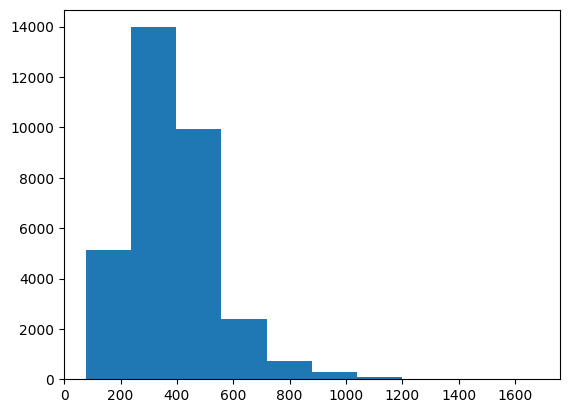

In [45]:
import matplotlib.pyplot as plt

plt.hist(max_length(train_tokens, max_train_list))


In [46]:
import numpy as np


def pad_sequences(sequences, max_length, pad_value):
    result = list()
    for sequence in sequences:
        sequence = sequence[:max_length]
        pad_length = max_length - len(sequence)
        padded_sequence = sequence + [pad_value] * pad_length
        result.append(padded_sequence)

    return np.asarray(result)


unk_id = token_to_id_train["<unk>"]
train_ids = [
    [token_to_id_train.get(token, unk_id) for token in text]
    for text in train["text_tokenize"]
]
test_ids = [
    [token_to_id_train.get(token, unk_id) for token in text]
    for text in test["text_tokenize"]
]

## 패딩
max_length = 1700
pad_id = token_to_id_train["<pad>"]
train_ids = pad_sequences(train_ids, max_length, pad_id)
test_ids = pad_sequences(test_ids, max_length, pad_id)


In [47]:
print(train_ids[0])
print(test_ids[0])


[   1    1 1579 ...    1    4    3]
[   1    1 1139 ...    1    1    5]


## [6] 모델 학습 준비


## [6-1] 단어 사전 저장


In [48]:
import json
from sklearn.feature_extraction.text import CountVectorizer

with open("vocab_kdy.json", "w") as f:
    json.dump(token_to_id_train, f)


In [49]:
# json -> 리스트 -> "단어" : idx 형식의 딕셔너리로 변환
import json

with open("vocab_kdy.json", "r", encoding="utf-8") as f:
    vocab_team1 = json.load(f)

vocab_dict = {}
for idx, word in enumerate(vocab_team1):
    vocab_dict[word] = idx
# print(vocab_dict)


In [50]:
# 저장
import pickle

# 단어 사전 저장
with open("vocab.pkl", "wb") as f:
    pickle.dump(token_to_id_train, f)

print("단어 사전이 저장되었습니다.")


# 불러오기
import pickle

# 단어 사전 불러오기
with open("vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

print("단어 사전이 불러와졌습니다.")
# print(vocab)


단어 사전이 저장되었습니다.
단어 사전이 불러와졌습니다.


In [51]:
# token_to_id_train


## [6-2] 모델 저장


In [52]:
SAVE_PATH = "../MODELS/dim_128_128/"

SAVE_FILE = "model_train_it_science.pth"

SAVE_MODEL = "model_train_it_science_all.pth"


In [53]:
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)


type(train.label.values)


In [54]:
train.label.values


array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

In [55]:
# 데이터로더 적용

import torch
from torch.utils.data import TensorDataset, DataLoader

train_ids = torch.tensor(train_ids)
test_ids = torch.tensor(test_ids)

## object 타입은 tensor로 변환이 불가하므로 label을 숫자형으로 변경
train_labels = torch.tensor(train.label.values, dtype=torch.float32)
test_labels = torch.tensor(test.label.values, dtype=torch.float32)

train_dataset = TensorDataset(train_ids, train_labels)
test_dataset = TensorDataset(test_ids, test_labels)

## 모델 학습 과정 시 각 step 마다 데이터를 batch size 크기로 분할하여 넣어 효과적이고 효율적인 학습 진행하도록
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [56]:
# 문장 분류 모델

from torch import nn


class SentenceClassifier(nn.Module):
    def __init__(
        self,
        n_vocab,
        hidden_dim,
        embedding_dim,
        n_layers,
        dropout=0.5,
        bidirectional=True,
        model_type="lstm",
    ):

        super().__init__()

        self.embedding = nn.Embedding(  # 인스턴스 생성
            num_embeddings=n_vocab, embedding_dim=embedding_dim, padding_idx=0
        )

        if model_type == "rnn":
            self.model = nn.RNN(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=n_layers,
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True,
            )

        elif model_type == "lstm":
            self.model = nn.LSTM(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=n_layers,
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True,
            )

        if bidirectional:
            self.classifier = nn.Linear(hidden_dim * 2, 1)
        else:
            self.classifier = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):  # 순방향 메서드
        embeddings = self.embedding(
            inputs
        )  # 입력받은 정수 인코딩을 임베딩 계층에 통과시켜 임베딩 값을 얻음
        output, _ = self.model(
            embeddings
        )  # 얻음 임베딩 값을 모델에 입력하여 출력값 얻음
        last_output = output[:, -1, :]
        last_output = self.dropout(last_output)
        logits = self.classifier(last_output)  # 마지막 값만 추출하여 분류기 계층에 전달
        return logits


In [57]:
# 손실함수와 최적화 함수 정의

from torch import optim

n_vocab = len(token_to_id_train)
hidden_dim = 64  # 은닉 상태 크기 64
embedding_dim = 64  # embedding 벡터 크기 64
n_layers = 4  # 신경망을 2개의 층으로 구성

# 기존엔 64 64

device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = SentenceClassifier(
    n_vocab=n_vocab,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    n_layers=n_layers,
).to(device)

criterion = nn.BCEWithLogitsLoss().to(device)

## RMSprop : 모든 기울기를 누적하지 않고, 지수 가중 이동 평균(EWMA)을 사용해 학습률 조절
## - 기울기 제곱 값의 평균값이 작아지면 학습률 증가, 반대일 경우 학습률을 감소시켜 불필요한 지역 최솟값에 빠지는 것 방지
## - 기울기의 크기가 큰 경우에는 빠른 수렴을 보이며 작은 경우에는 더 작은 학습률을 유지시켜 더 안정적으로 최적화 수행
optimizer = optim.RMSprop(classifier.parameters(), lr=0.001)

# 최적화 스케줄링 인스턴스 생성
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=5, verbose=True
)


c:\ProgramData\miniconda3\envs\Torch_NLP\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [58]:
# 모델 학습 및 테스트
# - 모델 학습 중간에 학습이 잘 이뤄지고 있는지 확인하기 위해 일정 배치 학습 후 테스트 데이터세트로 손실값 확인


def train_model(model, datasets, criterion, optimizer, device, interval):
    model.train()  # train 모드 설정
    losses = list()

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(
            1
        )  # unsqueeze : 지정한 자리에 size가 1인 빈 공간을 채워주면서 차원을 확장

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % interval == 0:
            print(f"Train Loss {step} : {np.mean(losses)}")


def test_model(model, datasets, criterion, device):
    model.eval()  # 검증 모드 설정
    losses = list()
    corrects = list()

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())
        yhat = torch.sigmoid(logits) > 0.5
        corrects.extend(torch.eq(yhat, labels).cpu().tolist())

    print(f"Val Loss : {np.mean(losses)}, Val Accuracy : {np.mean(corrects)}")
    return np.mean(losses), np.mean(corrects)


epochs = 100
interval = 500

## 위의 코드에서 정의한 criterion, optimizer 사용
for epoch in range(epochs):
    print(f"{epoch}/{epochs}")
    train_model(classifier, train_loader, criterion, optimizer, device, interval)
    loss_val, score_val = test_model(
        classifier, test_loader, criterion, device
    )  # 검증은 test 데이터셋으로 진행

    # 최적화 스케줄러 인스턴스 업데이트
    scheduler.step(score_val)
    print(f"scheduler.num_bad_epochs => {scheduler.num_bad_epochs}")

    SAVE_MODEL = SAVE_PATH + f"loss_{loss_val:.3f}_score{score_val:.3f}.pth"
    torch.save(classifier, SAVE_MODEL)

    # 손실감소(또는 성능개선)가 안되는 경우 조기 종료
    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f"성능 개선이 없어서 {scheduler.patience} EPOCH에 조기 종료함")
        break


0/100
Train Loss 0 : 0.6959785223007202
Train Loss 500 : 0.6846963947642587
Train Loss 1000 : 0.6843068413324765
Train Loss 1500 : 0.6847305669139656
Train Loss 2000 : 0.6846098312135341
Val Loss : 0.6895178008292403, Val Accuracy : 0.5258717660292463
scheduler.num_bad_epochs => 0
1/100
Train Loss 0 : 0.6295485496520996
Train Loss 500 : 0.6821969922431215
Train Loss 1000 : 0.6833849990522707
Train Loss 1500 : 0.6837016837268095
Train Loss 2000 : 0.6838810825455135
Val Loss : 0.6817474689866815, Val Accuracy : 0.5584926884139483
scheduler.num_bad_epochs => 0
2/100
Train Loss 0 : 0.6931332349777222
Train Loss 500 : 0.6769390664176789
Train Loss 1000 : 0.6791918662997274
Train Loss 1500 : 0.6794951535081324
Train Loss 2000 : 0.678911414490766
Val Loss : 0.6500809301755258, Val Accuracy : 0.6467941507311586
scheduler.num_bad_epochs => 0
3/100
Train Loss 0 : 0.6837470531463623
Train Loss 500 : 0.6696461738940485
Train Loss 1000 : 0.6639344432315865
Train Loss 1500 : 0.6534679430393597
Train